# Flood mapping with openEO
## interTwin
### Authors: 
    - Florian Roth
    - Bernhard Raml
    - Martin Schobben
    - Matthias Schramm

In this notebook we showcase openEO's standardization of remote sensing and Earth observation operations.

We do this by translating the flood mapping algorithm as presented in [@bauer-marschallinger_satellite-based_2022](https://www.mdpi.com/2072-4292/14/15/3673) to the openEO syntax of the Python Client.

This algorithm employs Sentinel-1 backscattered microwaves, so-called "sigma nought" or $\sigma^0$, to detect flooding.

In this exercise we will replicate the case study of the above mentioned paper, the February 2018 flooding of the Greek region of Thessaly.

## Setting-up a Python session

We begin by loading openEO and some additional packages. In this exercise we make use of a local variant of openEO as the data is not yet available on an accessible data store.

In [28]:
%%capture
pip install openeo[localprocessing] rioxarray cartopy eotransform_pandas geopathfinder scipy

In [7]:
from datetime import datetime
from pathlib import Path
import numpy as np

import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from eotransform_pandas.filesystem.gather import gather_files
from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention
from openeo.local import LocalConnection
from openeo.processes import ProcessBuilder, array_element, add, multiply, sin, cos, mask, exp

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


## Data sources

The paths to the local data sources define the collections to be loaded in the next steps. In the case of a local openEO instance, we do this by just supplying the paths to the files required for the analysis. 

In [9]:
ROOT_DATA = "./"

hparam_id = Path(f"{ROOT_DATA}openEO_local/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R3/EQUI7_EU020M/E054N006T3/D080.nc")
plia_id = Path(f"{ROOT_DATA}openEO_local/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E054N006T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__D080_E054N006T3_EU020M_V01R03_S1IWGRDH.nc")
sig0_id = Path(f"{ROOT_DATA}openEO_local/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E054N006T3/SIG0_20180228T043908__VV_D080_E054N006T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.nc")

## Connect to an openEO back-end

Establish the local connection by supplying path(s) to root directories of the data source(s). 

This results in a connection object which is a critical aspect of collection discovery on the back-end by openEO, where in this instance the back-end is your own machine. 

In [10]:
local_connection = LocalConnection([
    hparam_id.parent.as_posix(), 
    plia_id.parent.as_posix(), 
    sig0_id.parent.as_posix()
])

## Load collections

We can then load the collections. This is done by using the method `load_collection()` and by using the collection ids as defined above.

In [11]:
hparam_dc = local_connection.load_collection(str(hparam_id))
plia_dc = local_connection.load_collection(str(plia_id))
sig0_dc = local_connection.load_collection(str(sig0_id))

## openEO analysis

OpenEO supplies a set of conventional and EO-specific functions (or "processes" in openEO terminology) to work with EO data. In this example, we begin by defining functions that represent the flood mapping algorithm as defined in @bauer-marschallinger_satellite-based_2022, and by using standard openEO functions. The flood mapping algorithm extracts the following information: 1) the expected backscattering from water bodies, and 2) the expected backscatter intensity over land pixels given historical data. Hence, this function makes use of observations along both the spatial and temporal dimensions of the datacube.

We first define the function that extracts average backscatter intensity over water bodies and we name it `water_backscatter()`. This functions applies so-called openEO "band math", which are basically mathematical computations on the bands of the datacube. In this case, the band of the incidence angle (degrees) of the retrieved backscatter signal is multiplied by a factor consisting of the slope plus an intercept from a linear model. This linear model describes the relationship between incidence angle and backscattering over water globally. Applying this linear model results in expected water back scattering. In a follow-up, we use a so-called reducer function, taking the mean of the band over the time dimension, after which, we rename this dimension "wbsc" of type band.

In [17]:
def water_backscatter(plia_dc):
    return (plia_dc * -0.394181 + -4.142015).reduce_bands('mean'). \
        add_dimension('bands', 'wbsc', 'bands')

We can apply this function to the incidence angle datacube, as follows:

In [18]:
water_bsc_dc = water_backscatter(plia_dc)
water_bsc_dc

Here we can see the basic premise of openEO. The previous call did not actually perform the data processing it only generates a JSON representation of the processing graph.

Only by calling `execute()` on this object, we can actually perform the processing on the desired back-end, like so:

In [19]:
water_bsc_dc.execute()

<xarray.DataArray (bands: 1, y: 15000, x: 15000)>
dask.array<broadcast_to, shape=(1, 15000, 15000), dtype=float32, chunksize=(1, 2500, 2500), chunktype=numpy.ndarray>
Coordinates:
    band         int64 ...
  * x            (x) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.7e+06 5.7e+06 5.7e+06
  * y            (y) float64 9e+05 9e+05 9e+05 8.999e+05 ... 6e+05 6e+05 6e+05
    spatial_ref  int64 ...
  * bands        (bands) <U4 'wbsc'
Attributes:
    reduced_dimensions_min_values:  {'bands': 'PLIA'}

We define a second function to obtain expected backscattering over land pixels.

In this case we will have to use historical Sentinel-1 data for each pixel to negate the effect of seasons on the sigma nought signal. Hence a so-called harmonic model is fitted.

The following function `harmonic_expected_backscatter()` uses this harmonic model for estimations optimised to filter out seasonal signals. 

In [20]:
def harmonic_expected_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.band('M0')
    S1 = data.band('S1')
    S2 = data.band('S2')
    S3 = data.band('S3')
    C1 = data.band('C1')
    C2 = data.band('C2')
    C3 = data.band('C3')
    
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3.add_dimension('bands', 'hbsc', 'bands')

We can now again apply this function to a datacube.

For this operation we use the `hparam_dc` datacube defining the harmonic parameters of said model.

These parameters together with the date of the flooding event generate the expected backscattering per land pixel.

In [22]:
land_bsc_dc = harmonic_expected_backscatter(hparam_dc, '2018-02-01')

So far we have covered a couple of the core features of the openEO Python Client syntax. 

However, in all these cases, the shape of the datacube was not altered.

In the following section we cover what to do when want to change shape through accumulation or reduction of input values.

## Processes with child “callbacks”

Now we will define the last function, which calculates the probability of flooding with a Bayesian classification model. The output of this function tells if a pixel is flooded based on the previous defined expected land and water backscattering. The implementation of this function is, however, different from the previous functions, as it is applied to subsets of datacubes through the openEO function `reduce_bands()` and it thereby changes the shape of the input values. This family of functions, which also includes, e.g., `apply()`, `reduce_dimension()`, and `aggregate_spatial()`, are known as the "parent" functions. These parent functions invoke a subprocess on the datacube, so-called child "callbacks".

The following function will be used as a child callback to calculate flooding probabilities. Note that the function requires the openEO helper object `ProcessBuilder`. 

In [23]:
def bayesian_flood_decision(x: ProcessBuilder) -> ProcessBuilder:
    nf_std = 2.754041
    sig0 = x.array_element(index=0)
    std = x.array_element(index=1)
    wbsc = x.array_element(index=2)
    hbsc = x.array_element(index=3)
    
    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((sig0 - wbsc) / nf_std) ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((sig0 - hbsc) / nf_std) ** 2))
    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    f_post_prob = (f_prob * 0.5) /  evidence 
    nf_post_prob = (nf_prob * 0.5) /  evidence 
    
    # flood if flood class has higher probability
    return f_post_prob.gt(nf_post_prob)

We will use a child callback to reduce a datacube consisting of the expected backscatter over water, the expected backscattering over land and it's standard deviation, and the sigma nought values to one new band comprising the flood classifications per pixel.

For this we will first have to load the standard deviations of the expected land backscattering for each pixel and the sigma nought values for the particular timeperiod of the expected flooding (February 2018).

In [24]:
std_dc = hparam_dc.band('STD').add_dimension('bands', 'std', 'bands')
sig0_dc = sig0_dc.reduce_bands('mean').add_dimension('bands', 'sig0', 'bands')

Now we can merge all these datacubes, like so:


In [25]:
decision_in = sig0_dc.merge_cubes(std_dc).merge_cubes(water_bsc_dc).merge_cubes(land_bsc_dc)

This multi-band datacube is then used as input for the Bayesian flood mapping function that reduces all these bands to just one in the resulting datacube.

In [26]:
flood_decision = decision_in.reduce_bands(bayesian_flood_decision).execute()

## OpenEO flood mapping
We can check the results of the openEO defined flood mapping in the following plot.

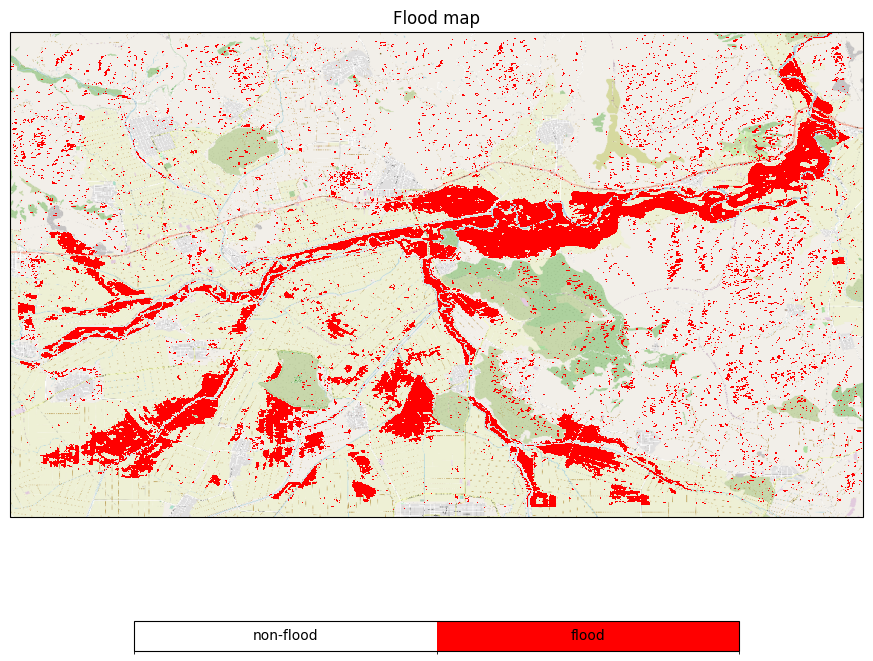

In [29]:
# selecting a subsection of the data and reprojecting
flood_map = flood_decision[13070:14000, 12900:14200]
flood_map = flood_map.rio.reproject(f"EPSG:4326", nodata=np.nan)
# add open streetmap
request = cimgt.OSM()
# initialize figure
fig = plt.figure(figsize=(13,9))
axis = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
axis.add_image(request, 15)
# add the data
flood_map = flood_map.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    levels=[0, 1, 2],
    colors=["#00000000", "#ff0000"],
    add_colorbar=False
)
# legend and title
cbar = fig.colorbar(flood_map, ax=axis, location="bottom", shrink=0.6)
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['non-flood','flood']):
    cbar.ax.text((2 * j + 1) / 2.0, 0.5, lab, ha='center', va='center')
cbar.ax.get_xaxis().labelpad = 10
tk = fig.gca()
tk = tk.set_title("Flood map")

By comparing this figure with the original study [@bauer-marschallinger_satellite-based_2022](https://www.mdpi.com/2072-4292/14/15/3673), we see that the openEO workflow can perform the same operations.

There are, however, some differences with the original flood mapping study.

These differences relate to the absence of the low sensitivity masking and post-processing steps of the flood probabilities in the openEO workflow. 

A priori low sensitivity masking removes observations in which situations arise that cause insensitivity to flood conditions for physical, geometric, or sensor-side reasons. Whereas, post-processing removes e.g. the small patches of supposed flooded pixels scattered throughout the image also known as "speckles". These speckles produce a more noisy picture in the openEO example.